In [1]:
import os
import regex
import glob
import multiprocessing as mp
import importlib
import pprint
import json

from typing import Tuple, Callable, Any, NoReturn, List, Dict, Optional, Union

from functools import partial, reduce

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

from pdf2image import convert_from_path, convert_from_bytes
import matplotlib.pyplot as plt
import cv2 as cv
import pytesseract

In [2]:
import timing
importlib.reload(timing)
import timing

In [3]:
# Instantiate a multiprocess pool.
pool = mp.Pool()

In [86]:
@timing.time_log()
def images_to_strings(x) -> Dict[str, List[str]]:
    """ Envoltura para generar un diccionario del tipo :
            {
                "nombre del archivo PDF": [Lista de strings, uno por página]
            }
        
        A partir de un diccionario del tipo:
            { 
                "nombre del achivo PDF": [Lista contendiendo una imagen por página]
            }
            
        
    """
    
    return {
        nombre: pool.map(pytesseract.image_to_string, archivo) for nombre, archivo in x.items()
    }
##

@timing.time_log()
def tab_by_regex(x: str) -> str:
    """
    """
    
    newline = lambda x: f"{x}\n"
    ntab    = lambda n, txt: n*"\t" + txt
    
    _x_lines: List[str] = x.split('\n')
    _my_str:  str       = ''
        
    for line in _x_lines:
        # Match lines starting with Caps, separated by spaces or points : 
        # r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))" # found on a separate cell down
        # r"^([A-Z\s]|[A-Z]\.?)+?(?=(\..+))" # the legacy regex for this func
        for i in regex.finditer(r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))", line): 
            _my_str += newline(i.string)
            _my_str += newline(ntab(1, i.group()))
            # Match numbers, which could be either integers or floats : 
            for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
                _my_str += newline(ntab(2, j.group()))
            # Match strings found between numbers :
            for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
                _my_str += newline(ntab(3, k.group()))
    
    return _my_str
##

@timing.time_log()
def dict_from_regex(x: str) -> str:
    """
        Genera un diccionario listo para ser serializado a JSON-Lines.
        
    """
    
    _x_lines: List[str] = x.split('\n')
    
    _dict2 = {}
    for line in _x_lines:
        for i in regex.finditer(r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))", line): 
            i.group()
            _valores = []
            _unidades = []
            # Match numbers, which could be either integers or floats : 
            for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string):
                _valores.append(float(j.group()))
            # Match strings found between numbers :
            for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
                _unidades.append(k.group())
            if len(_valores) < 5 and len(_unidades) < 5:
                _dict2.update({
                    i.group(): {
                        "values": _valores,
                        "units": _unidades
                    }
                })
                
            # We purge _dict2, allowing just matches having more than
            # one value, as is makes no sense to log void entries.
            _dict2 = {
                key: value for key, value in _dict2.items() if len(value['values']) > 0
            }
    
    return _dict2
##

@timing.time_log()
def dict_from_regex2(x: str, date: Optional[str] = None) -> str:
    """
        Genera un diccionario listo para ser serializado a JSON-Lines.
        
    """

    _x_lines: List[str] = x.split('\n')
    
    _dict2 = {}
    for line in _x_lines:
        for i in regex.finditer(r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))", line): 
            i.group()
            _valores = []
            _unidades = []
            # Match numbers, which could be either integers or floats : 
            for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string):
                _valores.append(float(j.group()))
            # Match strings found between numbers :
            for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
                _unidades.append(k.group())
            if len(_valores) < 5 and len(_unidades) < 5:
                _dict2.update({
                    i.group(): {
                        "values": _valores,
                        "units": _unidades
                    }
                })
                
            # We purge _dict2, allowing just matches having more than
            # one value, as is makes no sense to log void entries.
            _dict2 = {
                key: value for key, value in _dict2.items() if len(value['values']) > 0
            }
    
    if date is not None:
        return { date: _dict2 }
    else:
        return _dict2
##

@timing.time_log()
def save_results(x: Dict[str, List[str]]) -> bool:
    """
        Guarda los strings a los cuales ya se les han aplicado los filtros.
            
        El modo de escritura es 'w', o sea 'write'.
        Cada vez que se llame esta función los resultados anteriormente guardados 
        serán sobreescritos por los nuevos generados.
        
        La función crea un directorio llamado 'segmented' si es que 
        éste no existe.
        
        Después guarda todos los archivos en dicho directorio.
        
        Regresa:
            'True',  si se logran generar los archivos.
            
            'False', si ocurre algún error.
    """
    
    try:
        if 'segmented' not in os.listdir('.'):
            os.mkdir('segmented')
        
        _camino_resultados = os.path.abspath('segmented')
        _archivos =  list(x.keys())
    
        for i, archivo in enumerate(_archivos):
            for j, page in enumerate(x[archivo]):
                with open(os.path.join(_camino_resultados, f"{_archivos[i].replace('.pdf', '')}.{j+1}.txt"), 'w') as f:
                    f.write(tab_by_regex(page))
    
        return True
    except:
        return False
##                                    

@timing.time_log()
def extract_dates(
    x: Dict[str, List[str]], 
    exclude_date: Optional[str] = None
) -> Dict[str, List[str]]:
    """
        Busca las fechas en un diccionario del siguiente formato :
            { str: Dict[str, List[str]] }
            
        Genera un diccionario con las mismas llaves, pero con una lista 
        de las fechas que encontró en las hojas (cada uno de los strings 
        dentro de la lista).

    """
    
    dates = {}
    for nombre, lista in x.items():
        _tmp_list = []
        for string in lista:
            _tmp_list += list(set(
                regex.findall(r"(\d{2}\D[A-Z]{3}\D\d{4}|\d{2}\D\d{2}\D\d{4})", string)
            ))
        dates.update({
            nombre: list(set(_tmp_list))
        })

    if exclude_date is not None:
        for nombre, lista in dates.items():
            dates[nombre] = list(
                filter(lambda x: x if x != exclude_date else False, lista)
            )
    
    return dates
##
                                       
@timing.time_log()
def save_docs_to_jsonl(x: Dict[str, List[str]], filename: Optional[str] = None) -> bool:
    """
        Guarda los resultados en un archivo, cuyo nombre puede 
        ser opcionalmente especificado a través del parámetro 'filename'.
        
        El NOMBRE por defecto es :
            'resultados.jl'
            
        El nombre del archivo 'filename' puede ser un camino absoluto, si
        se desea guardar la información en algún otro lugar.
        
        POR DEFECTO se trata del mismo directorio :
            En la línea de comando :
                `pwd`
                
            Desde Python :
                os.path.abspath('.')
        
        El formato de registro es JSON-lines :
            http://jsonlines.org/
            
        El modo de edición del archivo es 'append', 
        es decir los nuevos registros se añaden, sin borrar 
        las líneas anteriores.
        
        Prámetros :
                   x: Diccionario { str: List[str] }, la información por guardar.
            filename: Opcional, str, nombre del archivo de registro.
    """
    
    try:
        _archivos = x.keys()
        _dates =  extract_dates(x)
        if filename is None:
            filename = 'resultados.jl'
                                       
        with open(filename, 'a') as f:
            for archivo in _archivos:
                for hoja in x[archivo]:
                    f.write(f"{json.dumps(dict_from_regex2(hoja, _dates[archivo]))}\n")
        return True
    except:
        return False
##

@timing.time_log()                                     
def build_string_from_dict(x: Union[Dict[str, List[str]], List[Dict[str, Any]]]) -> str:
    ''' 
        Construye una cadena de caracteres a partir de una de
        dos posibles estructuras anidadas :
        
        1. Diccionario :  {   str: List[str] }
        2. Lista       :  [ { str: Any }     ]
        
        Esta cadena de caracteres es óptima para la visualización.
    '''
    newline = lambda x: f"{x}\n"
    ntab = lambda n, txt: n*"\t" + txt
                                       
    my_string = ''
    
    if type(x) is list:
        for entry in x:
            for key in entry.keys():
                my_string += f'{key}: {entry[key]}\n'
            my_string += '\n\n'
    elif type(x) is dict:
        for key1, value in x.items():
            my_string += f"{key1}:\n"
            for key2 in value.keys():
                my_string += f'\t{key2}: {value[key2]}\n'
            my_string += '\n\n'
                                       
    
    return my_string
##

In [49]:
# Funciones de asistencia "helper functions" :
newline = lambda x: f"{x}\n"
ntab = lambda n, txt: n*"\t" + txt

In [50]:
path = os.path.abspath('analisis_clinicos/')
path

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos'

Aquí se encuentran todos los pdf con análisis clínicos que tenemos.

In [51]:
path_textos = os.path.abspath('textos')
path_textos

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/textos'

En esta dirección guardaremos todos los textos reconocidos por **pytesseract**.

In [52]:
caminos_textos = glob.glob(f"{path_textos}/*.txt")
caminos_textos.sort()
#caminos_textos

En esta dirección se almacenaron los textos que se extrajeron de los documentos a partir de **pytesseract**. Nótese que al procesar imagen por imagen, y al crear nosotros una imagen por cada página del pdf, los nombres que ahí se encuentran son los originales, sin la extensión pdf, con un punto indicando el nombre de página y con terminación txt.

```mi_archivo.pdf```  => ```mi_archivo.i.txt``` Donde **i** indica el número de página.

In [53]:
caminos = glob.glob(f"{path}/*.pdf")
#caminos

Esta lista contiene el camino hacia cada uno de los PDFs de los cuales se desean extraer los datos.

In [54]:
archivos = [ os.path.split(camino)[1] for camino in caminos]
archivos

['gustavo_maganna_2018-05-13.pdf',
 'gustavo_maganna_2018-05-06.pdf',
 'gustavo_maganna_2019-11-13.pdf',
 'Wed Nov 13 18:05:58 CST 2019.pdf',
 'InformeResultados1-110600.pdf',
 'gustavo_maganna_2018-01-19.pdf']

Nombre de los archivos PDF, sin el camino absoluto dentro del *filesystem*.

In [55]:
nombres = [ archivo.replace('.pdf', '') for archivo in archivos ]
nombres

['gustavo_maganna_2018-05-13',
 'gustavo_maganna_2018-05-06',
 'gustavo_maganna_2019-11-13',
 'Wed Nov 13 18:05:58 CST 2019',
 'InformeResultados1-110600',
 'gustavo_maganna_2018-01-19']

Nombre de los archivos, sin la extensión ```.pdf```.

In [56]:
parse_from_txt = True

if parse_from_txt:
    # Buscamos todos los archivos de texto :
    #   los nombres de archivo especificados por 'nombres'
    #   en el directorio especificado por 'path_textos'
    archivos_de_texto = { 
        archivo: glob.glob(os.path.join(path_textos ,f"{nombre}.?.txt")) 
        for archivo, nombre in zip(archivos, nombres)
    }
    # Los ordenamos, para que el orden de las páginas sea el mismo 
    # que en los PDFs :
    [ archivos_de_texto[key].sort() for key in archivos_de_texto.keys() ]
    
    # Creamos un diccionario vacío el cual contendrá todas las cadenas 
    # de acaracteres asociadas a cada una de las hojas de cada uno de los reportes
    # de análisis clínicos.
    strings = {}
    
    # Iteramos sobre cada uno de los nombres de archivo pdf
    for key in archivos_de_texto.keys():
        # Generamos una lista vacía para contener las 'n'
        # cadenas de caracteres, correspondientes a las 'n'
        # páginas de cada pdf.
        _strings = []
        for _file in archivos_de_texto[key]:
            # Iteramos sobre cada 'hoja' perteneciente al pdf especificado.
            with open(_file, 'r') as f:
              _strings.append(f.read())
        strings.update({
            # Añadimos el archivo como llave y 
            # la lista de strings como valor al diccionario.
            key: _strings
        })

In [57]:
# Obtain text from the PDFs, directly (this takes about a minute) : 
from_pdfs = False

if from_pdfs:
    # Para acelerar el proceso, generamos imágenes de forma paralela
    # gracias a pool.map :
    imagenes = pool.map(convert_from_path, caminos)
    # Construimos un diccionario con los nombres de archivos y las
    # imágenes obtenidas : 
    archivos_en_imagenes = {
        archivo: imagen for archivo, imagen in zip(archivos, imagenes)
    }
    # Generamos un nuevo diccionario, ahora con cadenas de caracteres
    # en lugar de imágenes, estas primeras obtenidas a través de 
    # pytesseract.
    # la función images_to_strings() utiliza a su vez pool.map, para
    # acelerar el proceso de extracción de caracteres.
    strings = images_to_strings(archivos_en_imagenes)

In [58]:
# Guardamos cada uno de los strings generados, 
# para poder posteriormente acceder a ellos sin necesidad de 
# repetir el procesamiento de imágenes, lo que conforme 
# crezca la base de datos del PDF, se hará más lento.
save = True

if save:
    for nombre, hojas in strings.items():
        for i, hoja in enumerate(hojas):
            _file_name = os.path.join(path_textos, f"{nombre.replace('.pdf', '')}.{i+1}.txt")
            with open(_file_name, "w") as f:
                f.write(hoja)

In [59]:
extract_dates(strings, exclude_date='06/08/1996')

{'gustavo_maganna_2018-05-13.pdf': ['13/05/2018'],
 'gustavo_maganna_2018-05-06.pdf': [],
 'gustavo_maganna_2019-11-13.pdf': ['13-NOV-2019'],
 'Wed Nov 13 18:05:58 CST 2019.pdf': ['13-NOV-2019'],
 'InformeResultados1-110600.pdf': ['15-NOV-2019'],
 'gustavo_maganna_2018-01-19.pdf': ['19-ENE-2018']}

Esta función que creamos ```extract_date()``` permite obtener fechas encontradas en un PDF, con flexibilidad en cuanto a formatos y la posibilidad de excluir una fecha especificada, que bien podría ser la fecha de cumpleaños del paciente.

In [78]:
example0 = False

if example0:
    print(tab_by_regex(strings[archivos[1]][0]))

Aquí observamos cómo la función que definimos ```tab_by_regex()``` puede identficar correctamente los parámetros de interés, aunque incluye datos que pueden no ser los deseados ya que el reconocimiento de caracteres de **pytesseract** no es perfecto.

Esto se deberá tomar en cuenta el momento de generar los registros.

In [83]:
example1 = True

if example1:
    ejemplo = dict_from_regex(strings['gustavo_maganna_2018-01-19.pdf'][0])
    print(build_string_from_dict(ejemplo))

DEPURACION DE CREATININA.:
	values: [133.6, 75.0, 115.0]
	units: [' mL/min']


CREATININA.:
	values: [0.92, 0.61, 1.24]
	units: [' mg/dL', ' -']


CREATININA URINARIA:
	values: [82.6, 39.0, 259.0]
	units: [' mg/dL', ' -']


SUP:
	values: [1.86, 2.0]
	units: []


MICROALBUMINURIA.:
	values: [10.0, 0.0, 100.0]
	units: [' mg/L']





Aquí pueden observarse los datos identificados de la primer hoja del pdf : 'gustavo_maganna_2018-01-19.pdf'

In [82]:
example2 = False

if example2:
    _file = archivos[1]
    print(f" Nombre del archivo: {_file}")
    print(f" Número de hojas: {len(strings[_file])}")
    _pagenum = 2
    print(f" Contenido de la hoja {_pagenum + 1}: \n\n {strings[_file][_pagenum]}")
    print("\n\n######################################################################\n\n")
    print("Parámetros encontrados : \n",build_string_from_dict(dict_from_regex(strings[_file][_pagenum]) ))

Este ejemplo permite contrastar el texto identificado por **pytesseract** y los valores obtenidos una vez que se ha aplicado nuestro sistema de filtro para encontrar los parámetros de interés.

In [71]:
save_docs_to_jsonl(strings)

True

Aquí hemos guardado los registros en un archivo JSON-Lines

In [72]:
save_results(strings)

True

Aquí hemos guardado el texto extraido de las imágenes.

In [77]:
example3 = False

if example3:
    for archivo in archivos:
        for hoja in strings[archivo]:
            print(build_string_from_dict(dict_from_regex(hoja)))
            #print(tab_by_regex(hoja))

In [66]:
# My regexps :

my_may_ge_2 = r"^[A-Z]{2,}"  # Find CAPITAL WORDS longer than 2, at the begining of the line.
my_numbers = r"(\d+\.\d+|\d+)" # Find numbers of any length, with a decimal point or not.
my_from_begining_until_point = r"^.+?(?=(\..+))" # Find any text before the first occurrence of a pint
my_caps_and_whitespace_until_point = r"^[A-Z\s]+?(?=(\..+))"
my_caps_and_whitspace_or_acronym_until_point = r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))"
my_failed_extract_units = r"(?<=((\d+\.\d+|\d+)+))(.+)"
googled_text_between_brackets = r"(?<=\[).+?(?=\])"
my_extract_units = r"(?<=(\d+\.\d+|\d+))\D+?(?=(\d+\.\d+|\d+))"
my_better_extract_units_between_numbers = r"(?<=(\d+\.\d+|\d+))\D[^\.\d]+?(?=(\d+\.\d+|\d+))"
my_extract_units_between_numbers_and_whitespace = r"(?<=(\d+\.\d+|\d+))\D[^\.\d]+?(?=\s)"

En esta celda podemos encontrar las expresiones regulares que fueron utilizadas en el proceso de exploración para así identificar las óptimas para poder extraer los datos de las hojas.

In [67]:
# Cuántas líneas tenemos en total :
caracteres_por_linea = pd.core.series.Series(
    [
     len(line) for line in page.split('\n') 
     for pdf in strings
     for page in pdf
    ],
    name='caracteres'
)

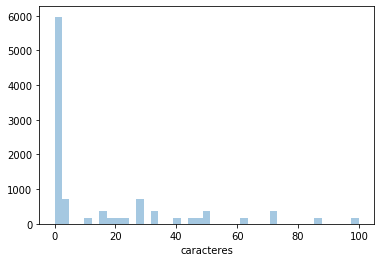

In [68]:
sns.distplot(caracteres_por_linea, kde=False)

In [42]:
pool.close()
pool.terminate()